In [1]:
library(Robyn)
packageVersion("Robyn")

[1] ‘3.11.1.9001’

In [38]:
# Install remotes to install Meta's Robyn from GitHub
#install.packages("remotes")

# Install Robyn package from Meta's GitHub repository
#remotes::install_github("facebookexperimental/Robyn/R")

# Install any additional dependencies if needed
#install.packages(c("jsonlite", "httr", "data.table", "prophet", "glmnet", "reticulate", "tidyverse"))


In [2]:

# Load the reticulate package
library(reticulate)
py_config()


# Ensure the Conda environment is being used
use_condaenv("R", required = TRUE)

# Check if nevergrad is available
if (!py_module_available("nevergrad")) {
  stop("Error: nevergrad is still not available.")
} else {
  print("nevergrad successfully installed and available.")
}

python:         /opt/conda/bin/python3
libpython:      /opt/conda/lib/libpython3.10.so
pythonhome:     /opt/conda:/opt/conda
version:        3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
numpy:          /opt/conda/lib/python3.10/site-packages/numpy
numpy_version:  1.25.2

NOTE: Python version was forced by PATH

python versions found: 
 /opt/conda/bin/python3
 /opt/conda/bin/python

ERROR: Error in use_condaenv("R", required = TRUE): Unable to locate conda environment 'R'.


In [11]:
# Load necessary libraries
library(Robyn)
library(dplyr)
library(readr)
library(reticulate)
source_file_name <- "fin_amc_mmm_tactic.csv"
# Read the CSV file
robyn_df <- read_csv(source_file_name)
amzn_df <- read_csv("eu5_amazon_sales_dates.csv")

# Replace NA values with the mean of their respective columns
robyn_df <- robyn_df %>%
  
  mutate(across(where(is.numeric), ~ ifelse(is.na(.), mean(., na.rm = TRUE), .)))

create_files <- TRUE
print("Data successfully imported from CSV")

# Display the first few rows and structure of the data
print(head(robyn_df))
print(str(robyn_df))
# Ensure the date column is in Date format
robyn_df$event_date_utc <- as.Date(robyn_df$date, format = "%m/%d/%Y")
robyn_df$start_date_per <- as.Date(robyn_df$event_date_utc)

Rows: 1179 Columns: 48
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): country, date
dbl (46): dpv, atc, orders, snss, total_product_sales, ntb_total_product_sal...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 110 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Country, Event
date (1): event_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Data successfully imported from CSV"
# A tibble: 6 × 48
  country date         dpv   atc orders  snss total_product_sales
  <chr>   <chr>      <dbl> <dbl>  <dbl> <dbl>               <dbl>
1 de      06/10/2024 18653  3631   2151 2702.              49074.
2 de      18/03/2024 12704  1964   1079 2702.              32159.
3 de      28/01/2024 21432  5237   3220    1               67749.
4 de      18/04/2024  9871  1744   1054 2702.              29868.
5 de      22/04/2024 11720  1991   1162 2702.              32885.
6 de      06/02/2024 27978  7283   4840 2702.              93712.
# ℹ 41 more variables: ntb_total_product_sales <dbl>, total_units_sold <dbl>,
#   dsp_recruit_cost <dbl>, dsp_recruit_impressions <dbl>,
#   dsp_recruit_clicks <dbl>, dsp_conversion_cost <dbl>,
#   dsp_conversion_impressions <dbl>, dsp_conversion_clicks <dbl>,
#   dsp_awareness_cost <dbl>, dsp_awareness_impressions <dbl>,
#   dsp_awareness_clicks <dbl>, sd_recruit_cost <dbl>,
#   sd_recruit_impressions <dbl>

In [12]:
# Load necessary libraries
library(dplyr)
library(lubridate)
library(parallel)

# Detect the number of cores
numCores <- detectCores()

# Use mclapply for parallel processing
result <- mclapply(1:10, function(x) x^2, mc.cores = numCores)
# Define variables for country
cust <- "mars-pne"
country <- "uk"

# Filter the data for the specific country and brand
filtered_data <- robyn_df %>% 
  filter(country == !!country )

                   
amzn_df_holiday<-amzn_df %>%
    filter(country == !!country )
# Ensure the date column is in Date format
filtered_data$start_date_per <- as.Date(filtered_data$start_date_per)

# Extract the minimum and maximum dates
window_start <- min(filtered_data$start_date_per, na.rm = TRUE)
window_end <- max(filtered_data$start_date_per, na.rm = TRUE)

prophet_country <- toupper(unique(filtered_data$country))
if (length(prophet_country) != 1) {
  stop("Filtered data should contain exactly one unique country value.")
}

# Print the extracted dates and country for verification
print(paste("Window Start:", window_start))
print(paste("Window End:", window_end))
print(paste("Prophet Country:", prophet_country))


create_files <- TRUE
                   
# Extract the date column from amzn_df_holiday
amzn_hol <- amzn_df_holiday$event_date



amzn_df_holiday

[1] "Window Start: 2023-01-10"
[1] "Window End: 2024-12-09"
[1] "Prophet Country: UK"


Country,Event,event_date
<chr>,<chr>,<date>
DE,Prime Day 2022,2022-07-12
DE,Prime Day 2022,2022-07-13
DE,October Prime Day 2022,2022-10-11
DE,October Prime Day 2022,2022-10-12
DE,Black Friday 2022,2022-11-25
DE,Cyber Monday 2022,2022-11-28
DE,Christmas 2022,2022-12-25
DE,Boxing Day 2022,2022-12-26
DE,Prime Day 2023,2023-07-11


In [13]:
# Ensure necessary libraries are loaded
library(dplyr)

# Compute non-channel derived metrics
robyn_df <- robyn_df %>%
  # Customer Conversion Metrics
  mutate(
    conversion_rate = orders / dpv,            # Conversion rate
    orders_per_dpv = orders / dpv,             # Orders per DPV
    atc_per_dpv = atc / dpv,                   # Add-to-cart per DPV
    
    # Sales Efficiency Metrics
    AOV = total_product_sales / orders,        # Average Order Value

   
    
    # New-to-Brand Metrics
    NTB_order_rate = ntb_total_product_sales / total_product_sales,  # NTB Order Rate
    
    # Lagged Variables
 AOV_lag1 = lag(AOV, 1),                   # 1-day lag for AOV
    conversion_rate_lag1 = lag(conversion_rate, 1),  # 1-day lag for Conversion Rate
     atc_per_dpv_lag1 = lag( atc_per_dpv, 1),
      snss_lag1=lag(snss,1),
    ntb_total_product_sales_lag1=lag(ntb_total_product_sales,1),
    # Time-Based Metrics
    day_of_week = as.factor(weekdays(robyn_df$event_date_utc)),     # Day of the week
    day_of_month = as.numeric(format(event_date_utc, "%d")),  # Day of the month
    

  )

# View the first few rows to ensure the calculations worked
head(robyn_df)
# Create a vector of Amazon sale dates (assuming format is YYYY-MM-DD)
amazon_sale_dates <- as.Date(c(
  # 2022 Major Sales Events
  "2022-07-12", "2022-07-13",  # Prime Day 2022
  "2022-10-11", "2022-10-12",  # October Prime Day 2022
  "2022-11-25", "2022-11-28",  # Black Friday & Cyber Monday 2022
  "2022-12-25", "2022-12-26",  # Christmas & Boxing Day 2022

  # 2023 Major Sales Events
  "2023-07-11", "2023-07-12",  # Prime Day 2023
  "2023-10-10", "2023-10-11",  # October Prime Day 2023
  "2023-11-24", "2023-11-27",  # Black Friday & Cyber Monday 2023
  "2023-12-25", "2023-12-26",  # Christmas & Boxing Day 2023

  # 2024 Major Sales Events
  "2024-07-16", "2024-07-17",  # Prime Day 2024
  "2024-10-08", "2024-10-09",  # October Prime Day 2024
  "2024-11-29", "2024-12-02",  # Black Friday & Cyber Monday 2024
  "2024-12-25", "2024-12-26",  # Christmas & Boxing Day 2024

  # 2025 Major Sales Events
  "2025-07-15", "2025-07-16",  # Prime Day 2025
  "2025-10-07", "2025-10-08",  # October Prime Day 2025
  "2025-11-28", "2025-12-01",  # Black Friday & Cyber Monday 2025
  "2025-12-25", "2025-12-26"   # Christmas & Boxing Day 2025
))

# Additional smaller sales events (Easter, Bank Holidays, Back to School)
smaller_sale_dates <- as.Date(c(
  "2022-04-15", "2022-04-18",  # Easter Sale 2022
  "2022-08-29",                # August Bank Holiday 2022
  "2022-09-01", "2022-09-05",  # Back to School 2022

  "2023-04-07", "2023-04-10",  # Easter Sale 2023
  "2023-08-28",                # August Bank Holiday 2023
  "2023-09-01", "2023-09-05",  # Back to School 2023

  "2024-03-29", "2024-04-01",  # Easter Sale 2024
  "2024-08-26",                # August Bank Holiday 2024
  "2024-09-02", "2024-09-06",  # Back to School 2024

  "2025-04-18", "2025-04-21",  # Easter Sale 2025
  "2025-08-25",                # August Bank Holiday 2025
  "2025-09-01", "2025-09-05"   # Back to School 2025
))


# Combine the major and smaller sale dates
all_amazon_sale_dates <- unique(c(amzn_hol))

# Sort the dates to ensure they are in order
all_amazon_sale_dates <- sort(all_amazon_sale_dates)


# Sort to have them in order
all_amazon_sale_dates <- sort(all_amazon_sale_dates)

# Add a binary flag indicating if a given date is an Amazon sale date
robyn_df <- robyn_df %>%
  mutate(is_amazon_sale = ifelse(event_date_utc %in% all_amazon_sale_dates, 1, 0))

# View the updated data
head(robyn_df)
# Check how many sale dates are flagged
table(robyn_df$is_amazon_sale)
amazon_sale_dates_df <- robyn_df %>%
  filter(is_amazon_sale == 1)

# View the filtered data
head(amazon_sale_dates_df)

# Check how many rows correspond to sale dates
nrow(amazon_sale_dates_df)

country,date,dpv,atc,orders,snss,total_product_sales,ntb_total_product_sales,total_units_sold,dsp_recruit_cost,⋯,atc_per_dpv,AOV,NTB_order_rate,AOV_lag1,conversion_rate_lag1,atc_per_dpv_lag1,snss_lag1,ntb_total_product_sales_lag1,day_of_week,day_of_month
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
de,06/10/2024,18653,3631,2151,2702.137,49074.09,12176.23,2579,3665.2938070,⋯,0.1946604,22.81455,0.2481193,NA,NA,NA,NA,NA,Monday,10
de,18/03/2024,12704,1964,1079,2702.137,32158.91,5180.41,1291,1855.6778990,⋯,0.1545970,29.80437,0.1610879,22.81455,0.11531657,0.1946604,2702.137,12176.23,NA,NA
de,28/01/2024,21432,5237,3220,1.000,67749.39,17372.26,3889,950.1231626,⋯,0.2443542,21.04018,0.2564194,29.80437,0.08493388,0.1545970,2702.137,5180.41,NA,NA
de,18/04/2024,9871,1744,1054,2702.137,29867.54,4933.40,1264,0.2507117,⋯,0.1766792,28.33732,0.1651760,21.04018,0.15024263,0.2443542,1.000,17372.26,NA,NA
de,22/04/2024,11720,1991,1162,2702.137,32884.97,5166.41,1450,0.5078904,⋯,0.1698805,28.30032,0.1571055,28.33732,0.10677743,0.1766792,2702.137,4933.40,NA,NA
de,06/02/2024,27978,7283,4840,2702.137,93712.24,25478.91,6104,953.8313597,⋯,0.2603117,19.36203,0.2718845,28.30032,0.09914676,0.1698805,2702.137,5166.41,Sunday,2


country,date,dpv,atc,orders,snss,total_product_sales,ntb_total_product_sales,total_units_sold,dsp_recruit_cost,⋯,AOV,NTB_order_rate,AOV_lag1,conversion_rate_lag1,atc_per_dpv_lag1,snss_lag1,ntb_total_product_sales_lag1,day_of_week,day_of_month,is_amazon_sale
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
de,06/10/2024,18653,3631,2151,2702.137,49074.09,12176.23,2579,3665.2938070,⋯,22.81455,0.2481193,NA,NA,NA,NA,NA,Monday,10,0
de,18/03/2024,12704,1964,1079,2702.137,32158.91,5180.41,1291,1855.6778990,⋯,29.80437,0.1610879,22.81455,0.11531657,0.1946604,2702.137,12176.23,NA,NA,0
de,28/01/2024,21432,5237,3220,1.000,67749.39,17372.26,3889,950.1231626,⋯,21.04018,0.2564194,29.80437,0.08493388,0.1545970,2702.137,5180.41,NA,NA,0
de,18/04/2024,9871,1744,1054,2702.137,29867.54,4933.40,1264,0.2507117,⋯,28.33732,0.1651760,21.04018,0.15024263,0.2443542,1.000,17372.26,NA,NA,0
de,22/04/2024,11720,1991,1162,2702.137,32884.97,5166.41,1450,0.5078904,⋯,28.30032,0.1571055,28.33732,0.10677743,0.1766792,2702.137,4933.40,NA,NA,0
de,06/02/2024,27978,7283,4840,2702.137,93712.24,25478.91,6104,953.8313597,⋯,19.36203,0.2718845,28.30032,0.09914676,0.1698805,2702.137,5166.41,Sunday,2,0



   0    1 
1146   33 

country,date,dpv,atc,orders,snss,total_product_sales,ntb_total_product_sales,total_units_sold,dsp_recruit_cost,⋯,AOV,NTB_order_rate,AOV_lag1,conversion_rate_lag1,atc_per_dpv_lag1,snss_lag1,ntb_total_product_sales_lag1,day_of_week,day_of_month,is_amazon_sale
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
fr,10/11/2023,7168,1609,757,344,23968.55,5088.50,1343,814.4259,⋯,31.66255,0.2122990,28.95712,0.1271100,0.2514066,221,3053.50,Wednesday,11,1
fr,07/11/2023,8102,1834,1018,368,29380.24,6171.28,1611,325.6435,⋯,28.86075,0.2100487,25.99141,0.1227097,0.2519286,171,2674.55,Tuesday,11,1
fr,07/09/2024,4614,1087,514,244,15939.37,3665.02,896,413.1480,⋯,31.01045,0.2299351,28.86075,0.1256480,0.2263639,368,6171.28,Tuesday,9,1
fr,09/02/2024,5967,1621,913,252,23547.73,6486.89,1374,243.8730,⋯,25.79160,0.2754784,29.45140,0.1293860,0.2423246,188,2677.13,Monday,2,1
fr,01/06/2024,3900,1184,680,254,19025.42,3799.48,1136,617.1600,⋯,27.97856,0.1997054,30.37963,0.1214115,0.2348983,385,6165.54,Saturday,6,1
uk,10/11/2023,59128,19542,10583,5685,244406.63,40027.17,19600,2133.6659,⋯,23.09427,0.1637728,25.16187,0.1741864,0.3141682,5579,32406.04,Wednesday,11,1


[1] 33

In [19]:
# Load necessary libraries
library(dplyr)
library(lubridate)
library(parallel)

# Detect the number of cores
numCores <- detectCores()

# Use mclapply for parallel processing
result <- mclapply(1:10, function(x) x^2, mc.cores = numCores)
# Define variables for country
cust <- "mars-pne"
num_cores <- parallel::detectCores() - 1  # Use one less than the total number of cores
memory.limit(size = 64000)  # Set memory limit to 64 GB

current_date <- "2024-09-2401"

# Format file names
input_collect_file <- paste0("InputCollect_", cust, "_", country, "_", current_date, ".rds")
output_models_file <- paste0("OutputModels_", cust, "_", country, "_", current_date, ".rds")
output_collect_file <- paste0("OutputCollect_", cust, "_", country, "_", current_date, ".rds")
# Filter the data for the specific country and brand
filtered_data <- robyn_df %>% 
  filter(country == !!country )

# Ensure the date column is in Date format
filtered_data$start_date_per <- as.Date(filtered_data$start_date_per)

# Extract the minimum and maximum dates
window_start <- min(filtered_data$start_date_per, na.rm = TRUE)
window_end <- max(filtered_data$start_date_per, na.rm = TRUE)

prophet_country <- toupper(unique(filtered_data$country))
if (length(prophet_country) != 1) {
  stop("Filtered data should contain exactly one unique country value.")
}

# Print the extracted dates and country for verification
print(paste("Window Start:", window_start))
print(paste("Window End:", window_end))
print(paste("Prophet Country:", prophet_country))
# Convert date strings to Date format
filtered_data$start_date_per <- as.Date(filtered_data$start_date_per, format = "%d/%m/%Y")

# Remove rows with missing dates
filtered_data <- filtered_data[!is.na(filtered_data$start_date_per), ]

# Define window start and end
window_start <- min(filtered_data$start_date_per, na.rm = TRUE)
window_end <- max(filtered_data$start_date_per, na.rm = TRUE)

# Ensure is_amazon_sale is logical
filtered_data$is_amazon_sale <- as.logical(filtered_data$is_amazon_sale)
filtered_data$is_amazon_sale <- as.logical(filtered_data$is_amazon_sale)

filtered_data$is_amazon_sale[is.na(filtered_data$is_amazon_sale)] <- FALSE

filtered_data <- filtered_data %>%
  mutate(across(where(is.numeric), ~ ifelse(is.na(.), median(., na.rm = TRUE), .)))


                   create_files <- TRUE

Warning message:
“'memory.limit()' is Windows-specific”


[1] Inf

[1] "Window Start: 2023-01-10"
[1] "Window End: 2024-12-09"
[1] "Prophet Country: UK"


In [44]:
filtered_data

country,event_date_utc,dpv,atc,orders,snss,total_product_sales,ntb_total_product_sales,dsp_total_cost,dsp_impressions,⋯,AOV,NTB_order_rate,AOV_lag1,conversion_rate_lag1,atc_per_dpv_lag1,snss_lag1,ntb_total_product_sales_lag1,day_of_week,day_of_month,is_amazon_sale
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<lgl>
uk,2024-09-12,1984,206,13465,0,180249.1,43547.49,2846.883,596366,⋯,13.38649,0.2415961,19.90955,42.6428571,0.3571429,0,3247.15,Thursday,12,FALSE
uk,2024-09-11,71259,21294,13786,0,184520.2,43857.86,2919.442,647454,⋯,13.38461,0.2376860,20.39283,0.1501730,0.2650519,0,3769.64,Wednesday,11,FALSE
uk,2024-09-10,70868,18775,12638,0,166457.6,39805.68,2908.680,665490,⋯,13.17120,0.2391341,22.02661,0.1210573,0.2318969,0,3527.17,Tuesday,10,FALSE
uk,2024-09-09,79364,21817,13754,0,185461.4,44344.62,1737.644,426443,⋯,13.48418,0.2391043,22.00337,0.1361673,0.2457377,0,3658.68,Monday,9,FALSE
uk,2024-09-08,72348,20133,12175,0,166371.8,43185.99,2700.871,731839,⋯,13.66503,0.2595752,19.70786,0.1252796,0.2338824,0,3060.58,Sunday,8,FALSE
uk,2024-09-07,81118,21917,13185,0,174759.1,42618.61,2406.529,629538,⋯,13.25439,0.2438706,21.12423,0.1233556,0.2352814,0,3694.67,Saturday,7,FALSE
uk,2024-09-06,74314,22563,13971,0,184917.0,42886.39,2841.990,609150,⋯,13.23578,0.2319223,22.48545,0.1347139,0.2509463,0,3319.07,Friday,6,FALSE
uk,2024-09-05,79858,23537,14148,0,187129.7,46427.60,3128.538,646703,⋯,13.22658,0.2481038,20.65230,0.1578083,0.2723168,0,3309.22,Thursday,5,FALSE
uk,2024-09-04,79484,24060,14178,0,190107.1,45596.43,3095.626,663898,⋯,13.40860,0.2398460,20.58940,0.1548936,0.2625532,0,4295.58,Wednesday,4,FALSE


In [45]:
str(robyn_df$snss_lag1)
str(robyn_df$is_amazon_sale)
str(robyn_df$ntb_total_product_sales)
# Count occurrences of TRUE, FALSE, and NA in the is_amazon_sale column
table(filtered_data$is_amazon_sale, useNA = "ifany")



 num [1:1185] NA 0 0 0 0 0 0 0 0 0 ...
 num [1:1185] 0 0 0 0 0 0 0 0 0 0 ...
 num [1:1185] 12870 3247 43547 14780 3770 ...



FALSE  TRUE 
  376    19 

In [23]:
# Define hyperparameters for each channel
hyperparameters <- list(
  # DSP hyperparameters
  dsp_recruit_cost_alphas = c(0.5, 1.0),
  dsp_recruit_cost_gammas = c(0.4, 0.5),
  dsp_recruit_cost_thetas = c(0.1, 0.3),
  
  dsp_conversion_cost_alphas = c(0.5, 1.0),
  dsp_conversion_cost_gammas = c(0.4, 0.5),
  dsp_conversion_cost_thetas = c(0.1, 0.3),
  
  dsp_awareness_cost_alphas = c(0.5, 1.0),
  dsp_awareness_cost_gammas = c(0.4, 0.5),
  dsp_awareness_cost_thetas = c(0.1, 0.3),

  # SD hyperparameters
  sd_recruit_cost_alphas = c(0.5, 1.0),
  sd_recruit_cost_gammas = c(0.2, 0.4),
  sd_recruit_cost_thetas = c(0.1, 0.3),

  sd_defend_cost_alphas = c(0.5, 1.0),
  sd_defend_cost_gammas = c(0.2, 0.4),
  sd_defend_cost_thetas = c(0.1, 0.3),

  sd_attack_cost_alphas = c(0.5, 1.0),
  sd_attack_cost_gammas = c(0.2, 0.4),
  sd_attack_cost_thetas = c(0.1, 0.3),

  # SP hyperparameters with wide alpha range
  sp_auto_cost_alphas = c(0.5, 3.0),
  sp_auto_cost_gammas = c(0.6, 0.9),
  sp_auto_cost_thetas = c(0.0, 0.3),

  sp_recruit_cost_alphas = c(0.5, 3.0),
  sp_recruit_cost_gammas = c(0.6, 0.9),
  sp_recruit_cost_thetas = c(0.0, 0.3),

  sp_attack_cost_alphas = c(0.5, 3.0),
  sp_attack_cost_gammas = c(0.6, 0.9),
  sp_attack_cost_thetas = c(0.0, 0.3),

  sp_defend_cost_alphas = c(0.5, 3.0),
  sp_defend_cost_gammas = c(0.6, 0.9),
  sp_defend_cost_thetas = c(0.0, 0.3),

  # SB hyperparameters
  sb_defend_cost_alphas = c(1.1, 1.8),
  sb_defend_cost_gammas = c(0.4, 0.5),
  sb_defend_cost_thetas = c(0.0, 0.1),

  sb_recruit_cost_alphas = c(1.1, 1.8),
  sb_recruit_cost_gammas = c(0.4, 0.5),
  sb_recruit_cost_thetas = c(0.0, 0.1),

  sb_attack_cost_alphas = c(1.1, 1.8),
  sb_attack_cost_gammas = c(0.4, 0.5),
  sb_attack_cost_thetas = c(0.0, 0.1)
)

# Update the channel names in the InputCollect function
InputCollect <- robyn_inputs(
  dt_input = filtered_data,
  dt_holidays = dt_prophet_holidays,
  date_var = "start_date_per",
  dep_var = "total_product_sales",
  dep_var_type = "revenue",
  prophet_vars = c("trend", "season", "holiday"),
  prophet_country = toupper(unique(filtered_data$country)),
paid_media_spends <- c(
  "dsp_recruit_cost",  # DSP Recruit
  "dsp_conversion_cost",  # DSP Conversion
  "dsp_awareness_cost",  # DSP Awareness
  "sd_recruit_cost",  # SD Recruit
  "sp_auto_cost",  # SP Auto
  "sb_defend_cost",  # SB Defend
  "sp_recruit_cost",  # SP Recruit
  "sp_attack_cost",  # SP Attack
  "sp_defend_cost",  # SP Defend
  "sb_recruit_cost",  # SB Recruit
  "sd_defend_cost",  # SD Defend
  "sb_attack_cost",  # SB Attack
  "sd_attack_cost"  # SD Attack
),
paid_media_vars <- c(
  "dsp_recruit_impressions",  # DSP Recruit
  "dsp_conversion_impressions",  # DSP Conversion
  "dsp_awareness_impressions",  # DSP Awareness
  "sd_recruit_impressions",  # SD Recruit
  "sp_auto_clicks",  # SP Auto
  "sb_defend_clicks",  # SB Defend
  "sp_recruit_clicks",  # SP Recruit
  "sp_attack_clicks",  # SP Attack
  "sp_defend_clicks",  # SP Defend
  "sb_recruit_clicks",  # SB Recruit
  "sd_defend_clicks",  # SD Defend
  "sb_attack_clicks",  # SB Attack
  "sd_attack_clicks"  # SD Attack
),
  window_start = min(filtered_data$start_date_per, na.rm = TRUE),
  window_end = max(filtered_data$start_date_per, na.rm = TRUE),
  context_vars = c("is_amazon_sale", "snss", "ntb_total_product_sales_lag1"),
  adstock = "geometric",
  hyperparameters = hyperparameters
)

Warning message in Ops.factor(x, 0):
“‘<=’ not meaningful for factors”
Automatically set these variables as 'factor_vars': 'is_amazon_sale'

Warning message in check_datadim(dt_input, all_ind_vars, rel = 10):
“There are 19 independent variables & 153 data points. We recommend row:column ratio of 10 to 1”
Warning message in check_hyperparameters(hyperparameters, adstock, paid_media_spends, :
“Automatically added missing hyperparameter range: 'train_size' = c(0.5, 0.8)”
>> Running feature engineering...

Warning message in .font_global(font, quiet = FALSE, ...):
“Font(s) 'Arial Narrow' not installed, with other name, or can't be found”
NOTE: potential improvement on splitting channels for better exposure fitting. Threshold (Minimum R2) = 0.8 
  Check: InputCollect$modNLS$plots outputs
  Weak relationship for: 'dsp_awareness_impressions', 'sd_recruit_impressions', 'sd_attack_clicks' and their spend



In [ ]:
available_cores <- parallel::detectCores()
print(available_cores)
# Define the directory to save the plots in the root folder
robyn_directory <- "./"

#memory.limit(size = 64000)  # Set memory limit to 64 GB
# Run the model with cross-validation
OutputModels <- robyn_run(
  InputCollect = InputCollect,
    
  cores = available_cores,
  iterations = 1000,
  trials = 5,  # Increased number of trials
  ts_validation = TRUE,  # Enable time series validation
 add_penalty_factor = TRUE,
)
current_date <- "2024-10-1001"
# Format file names
input_collect_file <- paste0("InputCollect_a_g_", cust, "_", country, "_", current_date, ".rds")
output_models_file <- paste0("OutputModels_a_g_", cust, "_", country, "_", current_date, ".rds")
output_collect_file <- paste0("OutputCollect_a_g_", cust, "_", country, "_", current_date, ".rds")
# Save key objects
saveRDS(InputCollect, file = input_collect_file)
saveRDS(OutputModels, file = output_models_file)

[1] 8


Warning message in check_iteration(InputCollect$calibration_input, iterations, trials, :
“We recommend to run at least 2000 iterations per trial and 5 trials to build initial model”
Input data has 153 days in total: 2023-01-10 to 2024-12-09

Initial model is built on rolling window of 153 day: 2023-01-10 to 2024-12-09

Time-series validation with train_size range of 50%-80% of the data...

Using geometric adstocking with 60 hyperparameters (60 to iterate + 0 fixed) on 8 cores

>>> Starting 5 trials with 1000 iterations each using TwoPointsDE nevergrad algorithm...

  Running trial 1 of 5



Picking joint bandwidth of 0.0346

Picking joint bandwidth of 0.0013



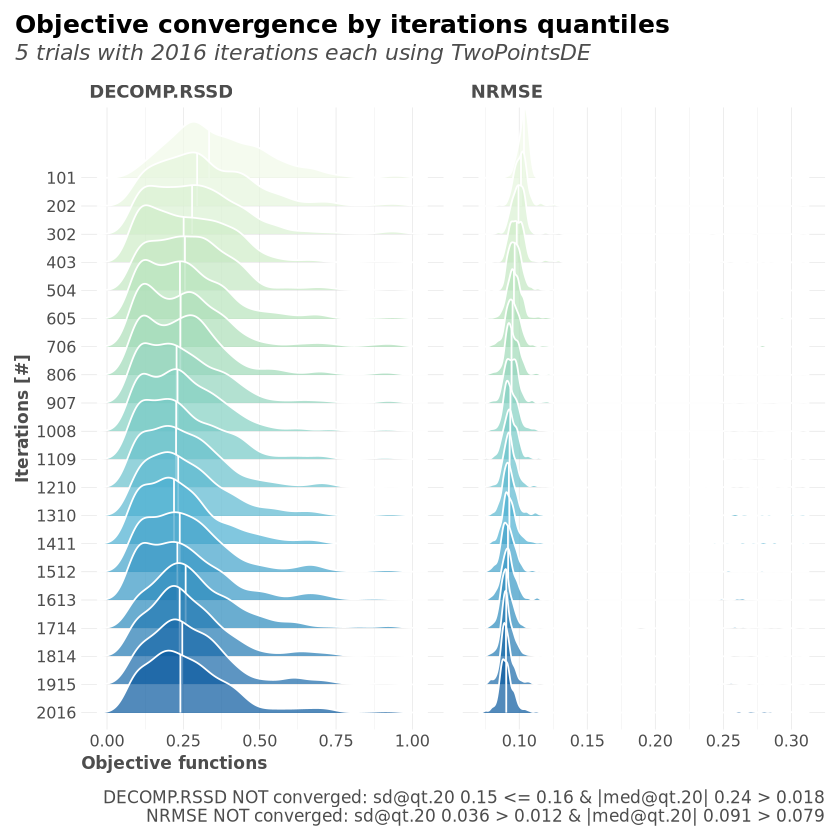

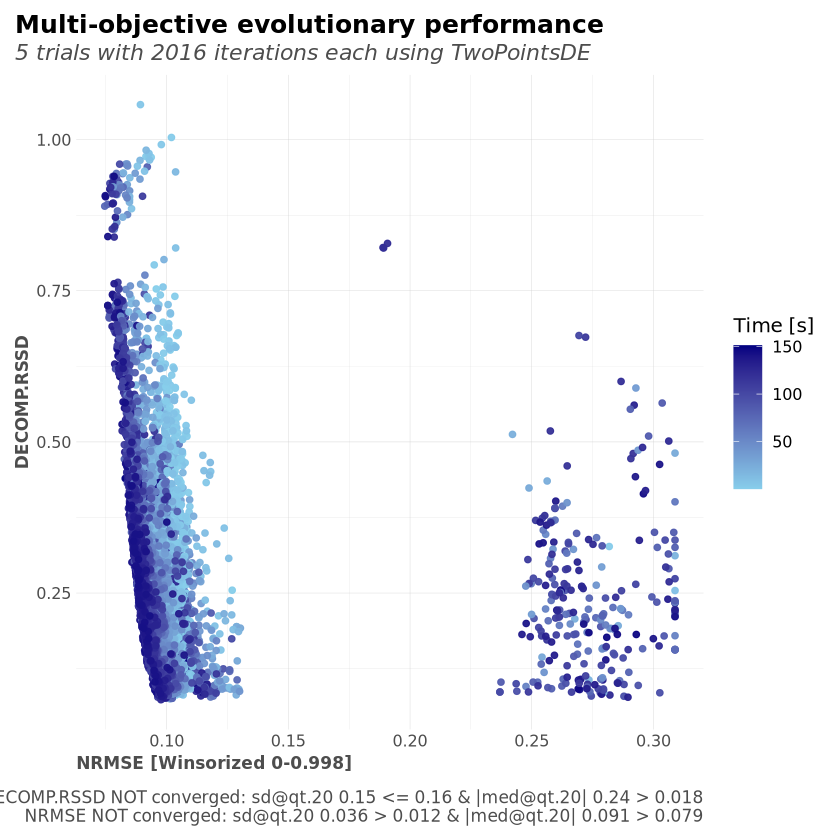

>>> Running Pareto calculations for 10000 models on 3 fronts...

>>> Calculating response curves for all models' media variables (872)...

>> Pareto-Front: 1 [54 models]



 00:00:08 [=========================================] 100% | 54                      


>> Pareto-Front: 2 [77 models]



 00:00:13 [=========================================] 100% | 77                      


>> Pareto-Front: 3 [87 models]



 00:00:16 [=========================================] 100% | 87                      


Creating directory for outputs: ./mars-pne_uk/Robyn_202409261422_init/

>>> Collecting 218 pareto-optimum results into: ./mars-pne_uk/Robyn_202409261422_init/

>> Exporting general plots into directory...

>> Exported models as ./mars-pne_uk/Robyn_202409261422_init/RobynModel-models.json



Plot Folder: ./mars-pne_uk/Robyn_202409261422_init/
Calibration Constraint: 0.1
Hyper-parameters fixed: FALSE
Pareto-front (3) All solutions (218): 1_44_24, 1_49_13, 1_53_13, 1_55_13, 1_56_28, 2_36_10, 2_39_10, 2_42_32, 2_45_11, 2_45_36, 2_48_1, 2_49_21, 2_50_8, 2_50_11, 2_51_3, 2_54_19, 2_54_23, 2_54_31, 2_55_35, 2_56_5, 2_56_13, 2_56_36, 3_36_11, 3_43_15, 3_46_13, 3_47_36, 3_48_13, 3_49_19, 3_50_34, 3_50_36, 3_51_34, 3_52_13, 3_54_14, 3_54_16, 3_55_16, 3_55_23, 3_55_24, 3_55_34, 3_56_16, 3_56_19, 3_56_24, 3_56_30, 3_56_34, 4_49_5, 4_52_5, 5_33_4, 5_34_4, 5_42_14, 5_44_26, 5_45_10, 5_52_22, 5_54_17, 5_55_17, 5_56_4, 1_37_25, 1_38_1, 1_40_24, 1_41_24, 1_45_23, 1_45_26, 1_47_2, 1_47_6, 1_48_6, 1_50_20, 1_50_23, 1_51_13, 1_51_36, 1_52_9, 1_53_33, 1_54_1, 1_55_12, 1_55_21, 1_55_31, 1_55_33, 2_36_29, 2_39_29, 2_44_3, 2_46_2, 2_47_3, 2_48_8, 2_48_12, 2_48_18, 2_49_8, 2_50_16, 2_51_8, 2_51_11, 2_51_21, 2_54_30, 2_55_18, 2_55_28, 3_37_25, 3_43_5, 3_45_34, 3_48_2, 3_49_13, 3_49_15, 3_49_16, 3_

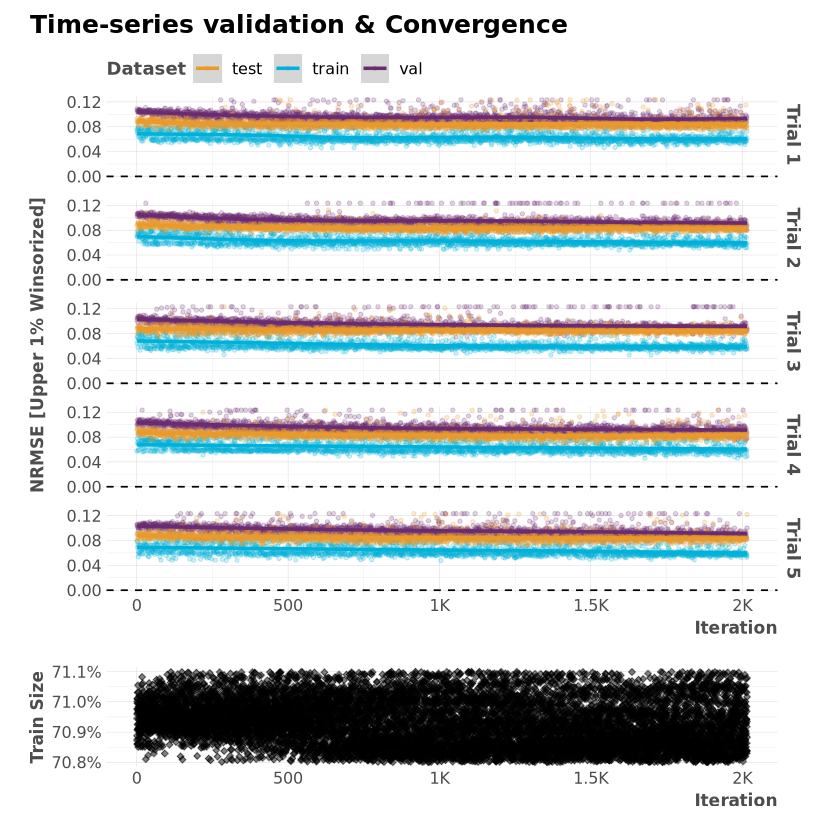

In [ ]:

#InputCollect <- readRDS(input_collect_file)

#OutputModels <- readRDS(output_models_file)



## Check MOO (multi-objective optimization) convergence plots
# Read more about convergence rules: ?robyn_converge
OutputModels$convergence$moo_distrb_plot
OutputModels$convergence$moo_cloud_plot
create_files=TRUE
## Check time-series validation plot (when ts_validation == TRUE)
# Read more and replicate results: ?ts_validation
if (OutputModels$ts_validation) OutputModels$ts_validation_plot
options(ragg.max_dim = 100000)

output_dir <- paste0("./",cust, "_", country)
## Calculate Pareto fronts, cluster and export results and plots. See ?robyn_outputs
OutputCollect <- robyn_outputs(
  InputCollect, OutputModels,
    cores = available_cores-5,
  pareto_fronts = 3, # Reduce the number of Pareto fronts to minimize memory usage
   min_candidates = 5, # Reduce the number of top Pareto models for clustering
  # calibration_constraint = 0.1, # range c(0.01, 0.1) & default at 0.1
  csv_out = TRUE, # Set to NULL to avoid writing CSV files
  clusters = FALSE, # Set to FALSE to avoid clustering similar models
  export = TRUE, # Set to FALSE to avoid creating files locally
  plot_folder = output_dir , # Set to NULL to avoid creating plot folders
  plot_pareto = FALSE # Set to FALSE to deactivate plotting and saving model one-pagers
)
print(OutputCollect)
print(OutputCollect)
saveRDS(OutputCollect, file = output_collect_file)


In [ ]:

# In subsequent sessions, start here:
#InputCollect <- readRDS(input_collect_file)

#OutputModels <- readRDS(output_models_file)
#OutputCollect <- readRDS(output_collect_file)

model_metrics <- data.frame()

for (model_id in OutputCollect$allSolutions) {
  model_data <- OutputCollect$xDecompAgg[OutputCollect$xDecompAgg$solID == model_id, ]
  
  metrics <- data.frame(
    model_id = model_id,
    nrmse = model_data$nrmse[1],
    decomp_rssd = model_data$decomp.rssd[1],
    rsq_train = model_data$rsq_train[1],
    mape = model_data$mape[1]
  )
  

  
  model_metrics <- rbind(model_metrics, metrics)
}

# Sort models by NRMSE (lower is better)
model_metrics_sorted <- model_metrics[order(model_metrics$nrmse), ]
print(model_metrics_sorted)

# Generate one-pagers for top 5 models
top_5_models <- head(model_metrics_sorted$model_id, 5)
for (model in top_5_models) {
  tryCatch({
    robyn_onepagers(InputCollect, OutputCollect, model, export = TRUE)
    cat("Generated one-pager for model:", model, "\n")
  }, error = function(e) {
    cat("Error generating one-pager for model", model, ":", conditionMessage(e), "\n")
  })
}


output_params_file <- paste0("OutputCollect_a_", cust, "_", country, "_", current_date, ".csv")

export_top_models_hyperparameters <- function(OutputCollect, top_n_models, output_dir="./") {
  # Extract hyperparameters for all top models
  top_models_hyperparameters <- OutputCollect$resultHypParam[OutputCollect$resultHypParam$solID %in% top_n_models, ]
  
  # Add model number (rank) to the hyperparameters
  top_models_hyperparameters$model_rank <- match(top_models_hyperparameters$solID, top_n_models)
  
  # Reorder columns to have model_rank first
  top_models_hyperparameters <- top_models_hyperparameters[, c("model_rank", setdiff(names(top_models_hyperparameters), "model_rank"))]
  
  # Create the output file path
  output_file <- file.path(output_dir, output_params_file)
  
  # Export to CSV
  write.csv(top_models_hyperparameters, file = output_file, row.names = FALSE)
  
  cat("Hyperparameters for top models exported to:", output_file, "\n")
  
  return(top_models_hyperparameters)
}

# Usage
top_n_models <- head(model_metrics_sorted$model_id, 50)


top_models_hyperparameters <- export_top_models_hyperparameters(OutputCollect, top_n_models, output_dir)

    model_id      nrmse decomp_rssd rsq_train mape
5    1_56_28 0.08299447  0.43960163 0.8794979    0
99   3_50_20 0.08362734  0.44944561 0.8820041    0
74   1_55_33 0.08369820  0.43992734 0.8795878    0
201  3_56_32 0.08379424  0.44170521 0.8813640    0
23   3_36_11 0.08386584  0.43163641 0.8799206    0
111  4_47_16 0.08423269  0.43726165 0.8753697    0
113  4_50_16 0.08425647  0.43218233 0.8768233    0
54    5_56_4 0.08427238  0.41184102 0.8793757    0
26   3_47_36 0.08432608  0.39005839 0.8767345    0
195   3_54_5 0.08441200  0.43520998 0.8792554    0
55   1_37_25 0.08441315  0.42766804 0.8784488    0
109  4_42_33 0.08449771  0.42551037 0.8772352    0
63    1_48_6 0.08458087  0.39108416 0.8746848    0
187  3_50_11 0.08469452  0.41819950 0.8786376    0
142   1_45_6 0.08469598  0.39234018 0.8776341    0
2    1_49_13 0.08469614  0.37950652 0.8766887    0
66   1_51_13 0.08469625  0.37952279 0.8766886    0
147  1_50_13 0.08473616  0.37959810 0.8766831    0
28   3_49_19 0.08492605  0.3725

Warning message:
“‘timedatectl’ indicates the non-existent timezone name ‘n/a’”
Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“‘/etc/localtime’ is not identical to any known timezone file”
Exporting charts as: ./mars-pne_uk/Robyn_202409261422_init/1_56_28.png



Generated one-pager for model: 1_56_28 


Warning message:
“‘timedatectl’ indicates the non-existent timezone name ‘n/a’”
Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“‘/etc/localtime’ is not identical to any known timezone file”
Exporting charts as: ./mars-pne_uk/Robyn_202409261422_init/3_50_20.png



Generated one-pager for model: 3_50_20 


Warning message:
“‘timedatectl’ indicates the non-existent timezone name ‘n/a’”
Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“‘/etc/localtime’ is not identical to any known timezone file”
Exporting charts as: ./mars-pne_uk/Robyn_202409261422_init/1_55_33.png



Generated one-pager for model: 1_55_33 


Warning message:
“‘timedatectl’ indicates the non-existent timezone name ‘n/a’”
Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“‘/etc/localtime’ is not identical to any known timezone file”
Exporting charts as: ./mars-pne_uk/Robyn_202409261422_init/3_56_32.png



Generated one-pager for model: 3_56_32 


Warning message:
“‘timedatectl’ indicates the non-existent timezone name ‘n/a’”
Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“‘/etc/localtime’ is not identical to any known timezone file”
Exporting charts as: ./mars-pne_uk/Robyn_202409261422_init/3_36_11.png



Generated one-pager for model: 3_36_11 
Hyperparameters for top models exported to: ./mars-pne_uk/OutputCollect_a_mars-pne_uk_2024-09-2602.csv 


In [ ]:
# Install the 'car' package if not already installed
install.packages("car")

# Load the package
library(car)

library(dplyr)


# Select relevant variables for VIF calculation (paid media spends, media vars, and context variables)
vif_vars <- robyn_df %>%
  select(total_product_sales,  snss, ntb_total_product_sales, dsp_total_cost, sp_total_cost,sb_total_cost,sd_total_cost,dsp_impressions, sp_clicks, sb_clicks, sd_clicks)


# Fit a linear model using all variables
model_vif <- lm(total_product_sales ~ ., data = vif_vars)


# Calculate VIF values for the model
vif_values <- vif(model_vif)

# View the VIF results
vif_df <- as.data.frame(vif_values)
vif_df

# Install the psych package
install.packages("psych")

# Load necessary library for factor analysis
library(psych)

# Perform factor analysis (choosing number of factors, say 3 here)
factor_analysis <- fa(vif_vars, nfactors = 7, rotate = "varimax")

# View factor analysis results
print(factor_analysis)


In [ ]:
# Select numeric columns only, excluding non-numeric columns like date and country
numeric_vars <- robyn_df %>%
  select_if(is.numeric)

# Compute the correlation matrix
cor_matrix <- cor(numeric_vars, use = "complete.obs")


# To specifically check correlation with 'total_product_sales'
cor_with_sales <- cor(numeric_vars$total_product_sales, numeric_vars, use = "complete.obs")
# Export cor_with_sales to a CSV file
write.csv(cor_with_sales, file = "correlation_with_sales.csv", row.names = FALSE)

# Confirm the export
print("Correlation data has been exported to 'correlation_with_sales.csv'")



In [ ]:
# Load libraries
library(ggplot2)

# Define the Weibull adstock function
weibull_adstock <- function(time, shape, scale) {
  return(1 - exp(-(time / scale)^shape))
}

# Set the time frame to visualize the curve (e.g., 0 to 10 days)
time <- seq(0, 10, by = 0.1)

# Extract hyperparameters from InputCollect
input_hyperparameters <- InputCollect$hyperparameters

# Extract shapes and scales for each channel (adjust these names based on actual structure)
sp_shape <- input_hyperparameters$sp_total_cost_shapes
sp_scale <- input_hyperparameters$sp_total_cost_scales
sb_shape <- input_hyperparameters$sb_total_cost_shapes
sb_scale <- input_hyperparameters$sb_total_cost_scales
dsp_shape <- input_hyperparameters$dsp_total_cost_shapes
dsp_scale <- input_hyperparameters$dsp_total_cost_scales
sd_shape <- input_hyperparameters$sd_total_cost_shapes
sd_scale <- input_hyperparameters$sd_total_cost_scales

# Calculate the adstock effect for each channel over time
dsp_adstock <- weibull_adstock(time, dsp_shape, dsp_scale)
sp_adstock <- weibull_adstock(time, sp_shape, sp_scale)
sb_adstock <- weibull_adstock(time, sb_shape, sb_scale)
sd_adstock <- weibull_adstock(time, sd_shape, sd_scale)

# Create a data frame for plotting
adstock_data <- data.frame(
  time = rep(time, 4),
  adstock = c(dsp_adstock, sp_adstock, sb_adstock, sd_adstock),
  channel = rep(c("DSP", "SP", "SB", "SD"), each = length(time))
)

# Plot the curves using ggplot2
ggplot(adstock_data, aes(x = time, y = adstock, color = channel)) +
  geom_line(size = 1) +
  labs(title = "Weibull Adstock Curves by Channel",
       x = "Time (days)",
       y = "Adstock Effect") +
  theme_minimal() +
  scale_color_manual(values = c("DSP" = "red", "SP" = "blue", "SB" = "green", "SD" = "purple"))


In [ ]:
# Check response decomposition
head(OutputCollect$decomped$all)

# Check spend data
head(OutputCollect$spend$all)

# Check adstock parameters
head(OutputCollect$adstock$all)

# Check ROAS and share of spend
head(OutputCollect$roi_all$all)


In [ ]:
# Assuming OutputCollect is already generated and you have a specific model ID
model_id <- model_metrics_sorted$model_id[1]  # Extract the actual model ID
print(paste("Selected model ID:", model_id))

# Debugging: Print unique solID values in OutputCollect
print("Unique solID values in xDecompAgg:")
print(unique(OutputCollect$xDecompAgg$solID))

# 1. Extract Response Decomposition for the specific model
response_decomp <- OutputCollect$xDecompAgg[OutputCollect$xDecompAgg$solID == model_id, ]

# Create a folder for outputs if it doesn't exist
if(!dir.exists("robyn_outputs")){
  dir.create("robyn_outputs")
}

# Check if the data is not null before writing to CSV
if (!is.null(response_decomp) && nrow(response_decomp) > 0) {
  write.csv(response_decomp, "robyn_outputs/response_decomp.csv", row.names = FALSE)
} else {
  print("response_decomp is null or empty")
}

# Confirmation message
print("Response decomposition data has been saved to the 'robyn_outputs' folder.")

In [ ]:
# Load necessary libraries
library(ggplot2)

# Assuming model_metrics_sorted is already created and contains the sorted model metrics
# Example: model_metrics_sorted <- model_metrics[order(model_metrics$nrmse), ]

# Extract the actual model ID
model_id <- model_metrics_sorted$model_id[1]
print(paste("Selected model ID:", model_id))

# Generate the one-pager for the selected model
myOnePager <- robyn_onepagers(InputCollect, OutputCollect, model_id, export = TRUE)

# Define the base directory to save the plots
base_plot_dir <- "./onepager_plots/"

# Ensure the directory exists
if (!dir.exists(base_plot_dir)) {
  dir.create(base_plot_dir, recursive = TRUE)
}

# Extract and save each plot separately
for (i in seq_along(myOnePager[[model_id]]$patches$plots)) {
  plot <- myOnePager[[model_id]]$patches$plots[[i]]
  plot_file <- paste0(base_plot_dir, "plot_", i, ".png")
  
  # Adjust the y-axis scale for the fourth plot
  if (i == 4) {
    # Extract the existing y-axis scale
    y_scale <- plot$scales$get_scales("y")
    
    # Modify the y-axis scale limits
    y_scale$limits <- c(0, 20000)
    
    # Apply the modified y-axis scale to the plot
    plot$scales$scales[[which(sapply(plot$scales$scales, function(x) x$aesthetics == "y"))]] <- y_scale
  }
  
  # Save the plot
  ggsave(plot_file, plot = plot, width = 10, height = 6)
  
  cat("Saved plot:", plot_file, "\n")
}

In [ ]:
   install.packages("ggplot2")
   library(ggplot2)

In [ ]:
# Inspect the structure of response_decomp
str(response_decomp)

# Print the first few rows to understand the data
head(response_decomp)

In [ ]:
# Load necessary libraries
library(ggplot2)
library(dplyr)
library(tidyr)
library(purrr)

# Assuming OutputCollect$xDecompAgg contains the necessary data
# Extract relevant columns (adjust column names as needed)
response_decomp <- OutputCollect$xDecompAgg %>%
  filter(solID == model_id) %>%  # Filter for the specific model ID
  select(rn, mean_spend, mean_response)  # Adjust column names as needed

# Check the structure of response_decomp to ensure it has the necessary columns
str(response_decomp)

# Check for NA values
print("Checking for NA values in mean_spend and mean_response columns:")
print(sum(is.na(response_decomp$mean_spend)))
print(sum(is.na(response_decomp$mean_response)))

# Filter out rows with NA values
response_decomp <- response_decomp %>%
  filter(!is.na(mean_spend) & !is.na(mean_response))

# Ensure the data frame is not empty
if (nrow(response_decomp) == 0) {
  stop("The data frame is empty after filtering out NA values.")
}

# Nest the data by rn (channel)
nested_data <- response_decomp %>%
  group_by(rn) %>%
  nest()

# Fit a logarithmic model for each channel
nested_data <- nested_data %>%
  mutate(model = map(data, ~ lm(mean_response ~ log(mean_spend + 1), data = .x)))

# Generate predicted values
nested_data <- nested_data %>%
  mutate(predictions = map2(data, model, ~ .x %>%
                              mutate(predicted_response = predict(.y, newdata = .x))))

# Unnest the data to get back to the original format
response_decomp <- nested_data %>%
  select(rn, predictions) %>%
  unnest(predictions)

# Create the plot
ggplot(response_decomp, aes(x = mean_spend, y = predicted_response, color = rn)) +
  geom_line(size = 1) +
  geom_text(data = response_decomp %>% group_by(rn) %>% top_n(1, mean_spend),
            aes(label = paste0(round(mean_spend / 1000, 2), "K")), vjust = -1) +
  labs(title = "Response Curves and Mean Spends by Channel",
       x = "Spend (carryover + immediate)",
       y = "Response",
       color = "Channel") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

# Save the plot
ggsave("robyn_outputs/response_curve.png", width = 10, height = 6)

In [ ]:
# Generate one-pagers for top 5 models
top_5_models <- head(model_metrics_sorted$model_id, 20)
for (model in top_5_models) {
  tryCatch({
    robyn_onepagers(InputCollect, OutputCollect, model, export = TRUE)
    cat("Generated one-pager for model:", model, "\n")
  }, error = function(e) {
    cat("Error generating one-pager for model", model, ":", conditionMessage(e), "\n")
  })
}

# Examine the convergence plots
print(OutputModels$convergence$moo_distrb_plot)
print(OutputModels$convergence$moo_cloud_plot)

In [ ]:
# Sort models by NRMSE (lower is better)
model_metrics_sorted <- model_metrics[order(model_metrics$nrmse), ]
print(model_metrics_sorted)

# Identify top 5 models based on NRMSE
top_5_models <- head(model_metrics_sorted, 5)
print("Top 5 models based on NRMSE:")
print(top_5_models)
top_1_models <- head(model_metrics_sorted, 1)
print(top_1_models)

In [ ]:


# Your model selection
select_model <- top_1_models
create_files <- TRUE
# Continue with your analysis
ExportedModel <- robyn_write(InputCollect, OutputCollect, select_model, export = create_files)
print(ExportedModel)

# To plot any model's one-pager:
myOnePager <- robyn_onepagers(InputCollect, OutputCollect, select_model, export = TRUE)

# To check each of the one-pager's plots
myOnePager[[select_model]]$patches$plots[[1]]
myOnePager[[select_model]]$patches$plots[[2]]
myOnePager[[select_model]]$patches$plots[[3]] # ...


print(ExportedModel)

In [ ]:
# Assume OutputCollect contains the model results
# best_model is a string identifier, not an object

best_model <- "8_276_22" # The identifier of the best model

# Extract the hyperparameters for the best model from OutputCollect
if (!is.null(OutputCollect) && "hyper_fixed" %in% names(OutputCollect)) {
  final_hyperparameters <- OutputCollect$hyper_fixed[[best_model]]
  
  if (!is.null(final_hyperparameters)) {
    print("Hyperparameters used in the best model:")
    print(final_hyperparameters)
  } else {
    print(paste("No hyperparameters found for model", best_model))
  }
} else {
  print("OutputCollect does not contain the expected structure for hyperparameters")
}

In [ ]:
export_top_models_hyperparameters <- function(OutputCollect, top_5_models, output_dir="./") {
  # Extract hyperparameters for all top models
  top_models_hyperparameters <- OutputCollect$resultHypParam[OutputCollect$resultHypParam$solID %in% top_5_models, ]
  
  # Add model number (rank) to the hyperparameters
  top_models_hyperparameters$model_rank <- match(top_models_hyperparameters$solID, top_5_models)
  
  # Reorder columns to have model_rank first
  top_models_hyperparameters <- top_models_hyperparameters[, c("model_rank", setdiff(names(top_models_hyperparameters), "model_rank"))]
  
  # Create the output file path
  output_file <- file.path(output_dir, "top_models_hyperparameters.csv")
  
  # Export to CSV
  write.csv(top_models_hyperparameters, file = output_file, row.names = FALSE)
  
  cat("Hyperparameters for top models exported to:", output_file, "\n")
  
  return(top_models_hyperparameters)
}

# Usage
best_model <- "31_190_36" # The identifier of the best model
top_5_models <- c("31_190_36", "31_189_36", "31_191_36", "31_194_36", "31_200_36",
                  "31_265_36", "31_266_36", "31_269_36", "31_278_36", "31_264_36",
                  "31_264_25", "31_273_25", "31_273_23", "31_275_23", "31_259_23",
                  "31_260_23", "31_273_20", "31_274_20", "31_275_20", "31_277_20")

output_dir="./"
top_models_hyperparameters <- export_top_models_hyperparameters(OutputCollect, top_5_models, output_dir)

In [ ]:

################################################################
#### Step 5: Get budget allocation based on the selected model above

## Budget allocation result requires further validation. Please use this recommendation with caution.
## Don't interpret budget allocation result if selected model above doesn't meet business expectation.

# Check media summary for selected model
print(ExportedModel)

# Run ?robyn_allocator to check parameter definition

# NOTE: The order of constraints should follow:
InputCollect$paid_media_spends


AllocatorCollect <- robyn_allocator(
  InputCollect = InputCollect,
  OutputCollect = OutputCollect,
  select_model = select_model,
  channel_constr_low = 0.7, # Single value for all channels
  channel_constr_up = 1.5,  # Single value for all channels
  scenario = "max_response",
  export = create_files
)
print(AllocatorCollect)
plot(AllocatorCollect)

In [ ]:

# Define the base folder where you want to save the results
base_output_folder <- "./"

# Create a subfolder with brand and country information
output_subfolder <- paste0(brand_name, "_", country, "_Q1_2024")

# Ensure the base folder exists
if (!dir.exists(base_output_folder)) {
  dir.create(base_output_folder, recursive = TRUE)
}

# Run the allocator with export enabled and custom subfolder
AllocatorCollectQ1_2024 <- robyn_allocator(
  InputCollect = InputCollect,
  OutputCollect = OutputCollect,
  select_model = select_model,
  date_range = c("2024-01-01", "2024-03-31"), # Date range for Q1 2024
  total_budget = 7000000, # Increased budget for growth
  channel_constr_low = c(1.0, 1.0, 1.0, 1.0, 1.0), # Ensure minimum spend is maintained
  channel_constr_up = c(2.0, 2.0, 2.0, 2.0, 2.0), # Allow higher spend for growth
  scenario = "max_response", # Maximize response to drive growth
  export = TRUE, # Enable export
  plot_folder = base_output_folder, # Specify the base output folder
  plot_folder_sub = output_subfolder # Specify the custom subfolder
)

# Print and plot the allocator's output
print(AllocatorCollectQ1_2024)